In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
# from last time
def run_sim(N0, gen_fn, ngens, dtype='int', **kwargs):
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    for t in range(1, ngens):
        N[t, :] = gen_fn(N[t-1, :], **kwargs)
    return N

# Differential equation models

Today we'll look at *differential equation* models,
which are

1. deterministic (not random), and
2. continuous-time.

Both of these are approximations, at least at some level,
but provide a very useful big-picture look at how a model "ought to behave".

## The logistic model

Last time we studied a model of *logistic population growth*.
Reparameterizing a bit,
in this model the population size at time step $k$, denoted $N_k$,
satisfies
$$\begin{aligned}
  N_{k+1} - N_k &= N_k \left( \lambda - \mu - \frac{\lambda N_k}{K} \right) + \epsilon,
\end{aligned}$$
where

- $\mu$ is the probability an individual dies before to the next time step,
- $\lambda$ is the mean unconstrainted number of offspring per time step,
- $K$ is the "carrying capacity", and
- $\epsilon$ is "noise", with mean zero and variance proportional to the number of births and deaths.

Imagine our first model was very coarse-grained:
we'd defined one "time step" to be 100 years,
and now we want to refine it, using the "same" model,
but with one time step equal to *one* year.
To do this, we'd need to:

- divide $\mu$ by 100 (so the mean number of deaths per 100 years would be the same), and
- divide $\lambda$ by 100 (same, for births).

The carrying capacity would stay the same, 
and the variance of $\epsilon$ would decrease 
along with the number of births and deaths per time step.

Let's say instead that one original time step is one "unit of time", 
that we now break up into $T$ time steps.
Then, the equation above is:
$$\begin{aligned}
  N_{t+1/T} - N_t &= \frac{1}{T} N_t \left( \lambda - \mu - \frac{\lambda N_t}{K} \right) + \epsilon .
\end{aligned}$$

The first idea of how this should behave comes from by ignoring noise
(setting $\epsilon = 0$).
Then, multiplying by $T$ and taking $T \to \infty$
(the limit of small time steps),
we end up with the *logistic equation*,
$$\begin{aligned}
  \frac{d}{dt} N_t &= N_t \left( \lambda - \mu - \frac{\lambda N_t}{K} \right).
\end{aligned}$$
(Well, it's the logistic equation we'd find [on Wikipedia](https://en.wikipedia.org/wiki/Logistic_function#Applications)
if we set $r = \lambda - \mu$ and change $K$ to $K r / \lambda$.)

**Solving differential equations**
can be done with [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html).
How's this differ from iterating the discrete, deterministic equation?
Not much, in this case.

In [4]:
lam = 0.1
mu = 1 - 0.95
K = 2000
def logistic_eqn(t, y):
    return y * (lam - mu - lam * y / K)
    
y0 = np.array([0.6, 0.8, 1.0, 1.2, 1.4]) * K / 2
logistic_solns = scipy.integrate.solve_ivp(
                      fun = logistic_eqn, 
                      t_span = (0.0, 120.0),
                      y0 = y0,
                      t_eval=np.arange(2*120)/2)

In [5]:
logistic_solns.keys()

dict_keys(['t', 'y', 'sol', 't_events', 'nfev', 'njev', 'nlu', 'status', 'message', 'success'])

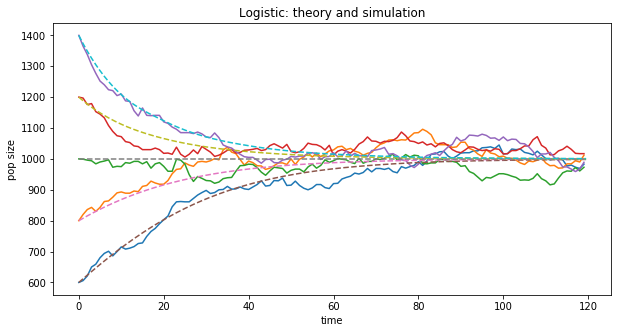

In [6]:
def logistic_gen(N, lam, mu, K):
    return (np.random.poisson(lam * N * np.fmax(0.0, 1 - N / K), len(N)) 
            + np.random.binomial(N, 1 - mu, len(N)))


N = run_sim(y0, 
            gen_fn=logistic_gen, ngens=120, 
            lam=lam, mu=mu, K=K)

plt.plot(N)
plt.plot(logistic_solns.t, logistic_solns.y.T, linestyle='--')
plt.xlabel("time")
plt.ylabel("pop size")
plt.title("Logistic: theory and simulation")
plt.show()

### Exercise

Compare the solution to the differential equation
to iteration of the deterministic equation we had before:

In [7]:
def logistic_step(N, lam, mu, K):
    return N + (lam - mu) * N * (1 - lam * N / (K * (lam - mu)))

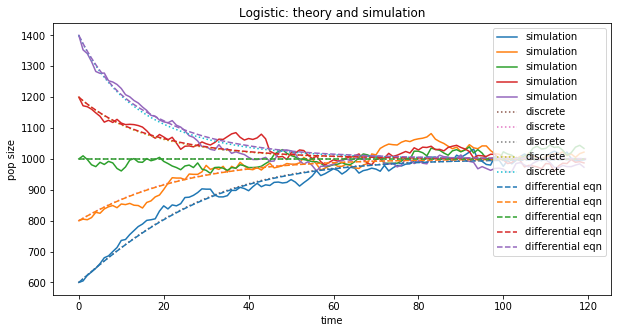

In [8]:
N = run_sim(y0, 
            gen_fn=logistic_gen, ngens=120, 
            lam=lam, mu=mu, K=K)
N_deterministic = run_sim(y0, 
            gen_fn=logistic_step, ngens=120, dtype='float',
            lam=lam, mu=mu, K=K)

plt.plot(N, label='simulation')
plt.plot(N_deterministic, linestyle=':', label='discrete')
plt.plot(logistic_solns.t, logistic_solns.y.T, linestyle='--', label='differential eqn')
plt.xlabel("time")
plt.ylabel("pop size")
plt.title("Logistic: theory and simulation")
plt.legend(loc="upper right")
plt.show()

## Two-dimensional models

Next we'll look at a common model of *two* populations.
First, here's some code that will come in handy,
for running simulations (`run_sim_2d( )`, much as before.

*Exercise:* Document the function below.

In [9]:
def run_sim_2d(N0, M0, gen_fn, ngens, dtype='int', **kwargs):
    """
    N0, M0: initial population size arrays for the two populations
    gen_fn: function that calculates the next generation of population sizes
        given the current population sizes. Takes in two arrays and other arguments
        and outputs a tuple of length two of the next generation's population sizes.
    ngens: number of generations to do this for
    dtype: the numpy type (eg either 'int' or 'float') that gen_fn returns
    **kwargs : the other parameters for gen_fn
    
    returns: a tuple of arrays, each of size (ngens, len(N0)),
        with columns corresponding to replicates and rows corresponding to time points
    """
    assert(len(N0) == len(M0))
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    M = np.empty((ngens, len(M0)), dtype=dtype)
    M[0, :] = M0
    for t in range(1, ngens):
        n, m = gen_fn(N[t-1, :], M[t-1, :], **kwargs)
        assert(n.dtype == dtype and m.dtype == dtype)
        N[t, :], M[t, :] = n, m
    return N, M


## Species interactions



Let's generalize logistic-type population dynamics to more types:

1. Each time step, each type-0 individual has probability $p_0$ of dying;
   those who die leave behind a Poisson number of offspring.
2. The mean number of offspring depends on the current amount of resources:
   it is equal to $\lambda_0 \exp(- (N + a_0 M)/K_0)$ when there are $N$ and $M$ individuals of the two types, respectively.
3. Same, vice-versa.

*Note:* here death and reproduction are coupled, like for an annual plant.

How do we expect this to behave?
Let's write down the *expected* dynamics:
$$\begin{aligned}
  \mathbb{E}[N_{t+1} | N_t = N, M_t = M]
      &= F(N, M) \\
      &= N (1 - p_0) + p_0 N \lambda_0 \exp(- (N + a_0 M)/K_0) \\
  \mathbb{E}[M_{t+1} | N_t = N, M_t = M]
      &= G(N, M) \\
      &= M (1 - p_1) + p_1 N \lambda_1 \exp(- (M + a_1 N)/K_1) .
\end{aligned}$$


### Aside: the Lotka-Volterra equations

The differential equation we'd get here are:
$$\begin{aligned}
  \frac{dN}{dt}
      &= r_0 N_t \exp\left( - \frac{N_t + a_0 M_t}{K_0} \right) \\
  \frac{dM}{dt}
      &= r_1 M_t \exp\left( - \frac{M_t + a_1 N_t}{K_1} \right) 
\end{aligned}$$
This is a multivariate version of the Ricker model;
the more famous Lotka-Volterra equations is the "logistic" analogue,
with $(1-N/K)$ instead of $\exp(-N/K)$.

### Simulation

First, let's look at the time series of the two population sizes,
both from a stochastic simulation
and iteration of the deterministic equations.
(If they don't look similar, we probably made a mistake.)

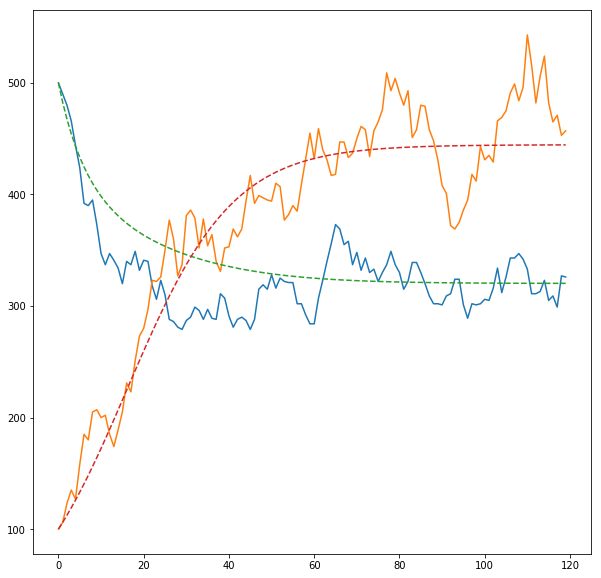

In [24]:
def lv_eqn(N, M, lam, p, K, a):
    next_N = N + p[0] * N * (lam[0] * np.exp(-(N + a[0] * M)/K[0]) - 1)
    next_M = M + p[1] * M * (lam[1] * np.exp(-(M + a[1] * N)/K[1]) - 1)
    return next_N, next_M

def lv_gen(N, M, lam, p, K, a):
    assert(len(M) == len(N))
    N_dies = np.random.binomial(N, p[0])
    M_dies = np.random.binomial(M, p[1])
    N_repro = np.random.poisson(N_dies * lam[0] * np.exp(-((N + a[0]*M)/K[0])))
    M_repro = np.random.poisson(M_dies * lam[1] * np.exp(-((M + a[1]*N)/K[1])))
    next_N = N - N_dies + N_repro
    next_M = M - M_dies + M_repro
    return next_N, next_M

# we'll use **kwargs to avoid re-typing these over and over
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # death prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }

# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)
# deterministic
tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                    **lv_args)

plt.plot(np.column_stack([N, M]))
plt.plot(np.column_stack([tN, tM]), linestyle="--")
plt.show()

### Equilibrium

Note that $\mathbb{E}[N_{t+1}] = N$ only if 
$\lambda_0 \exp(- (N + a_0 M)/K_0) = 1$,
and this happens only if
$(N + a_0 M)/K_0 = \log \lambda_0$.

Writing out the equations for both species,
equilibrium occurs when
$$\begin{aligned}
  N + a_0 M &= K_0 \log(\lambda_0) \\
  a_1 N + M &= K_1 \log(\lambda_1)  
\end{aligned}$$
which is solved by
$$\begin{aligned}
  N &= \frac{K_0 \log(\lambda_0) - a_0 K_1 \log(\lambda_1)}{1 - a_0 a_1} \\
  M &= \frac{K_1 \log(\lambda_1) - a_1 K_0 \log(\lambda_0)}{1 - a_0 a_1} .
\end{aligned}$$

In [26]:
def lv_equil(lam, p, K, a):
    return np.array([K[0] * np.log(lam[0]) - a[0] * K[1] * np.log(lam[1]),
                     K[1] * np.log(lam[1]) - a[1] * K[0] * np.log(lam[0])]) / (1 - a[0] * a[1])


equil = lv_equil(**lv_args)
print("equilibrium:", equil)

equilibrium: [320.18992291 444.53190673]


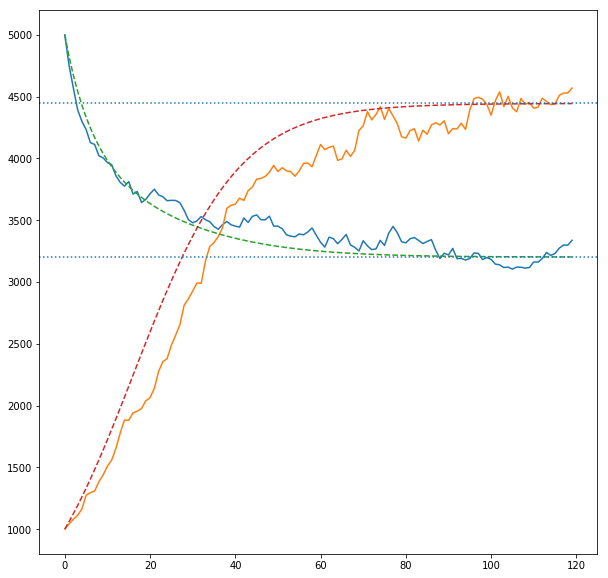

In [23]:
# we'll use **kwargs to avoid re-typing these over and over
big_lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # death prob
        'K' : [20000, 50000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }

# random simulation
N, M = run_sim_2d([5000], [1000], lv_gen, 120, dtype='int',
                    **big_lv_args)
# deterministic
tN, tM = run_sim_2d([5000], [1000], lv_eqn, 120, dtype='float',
                    **big_lv_args)
equil = lv_equil(**big_lv_args)

plt.plot(np.column_stack([N, M]))
plt.plot(np.column_stack([tN, tM]), linestyle="--")
for a in equil:
    plt.axhline(a, linestyle=":")
plt.show()

### Phase plots

We really want to think of the basic equations
as telling us which way the system is "pushed".
A nice way to view this is as a *vector field* of arrows
in *phase space*.
Here is code to make these plots.
(But, you should probably look at the result, first!)

In [32]:
def phase_plot(genfn, xlim, ylim, nx, ny, **kwargs):
    xstep = int((xlim[1] - xlim[0]) / nx)
    ystep = int((ylim[1] - ylim[0]) / ny)
    X, Y = np.meshgrid(range(xlim[0], xlim[1], xstep), range(ylim[0], ylim[1], ystep))
    X.shape = Y.shape = (np.prod(X.shape),)
    U, V = genfn(X, Y, **kwargs)
    fig, ax = plt.subplots()
    ax = fig.add_subplot(111)
    ax.quiver(X, Y, U-X, V-Y, angles='xy', scale_units='xy', scale=1)
    return fig

Here is a phase plot for this system,
along with the deterministic trajectory starting from a single point,
and converging to the equilibrium.

In [43]:
def do_plot(lv_args):  
    equil = lv_equil(**lv_args)

    tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                        **lv_args)

    plt.rcParams['figure.figsize'] = [10, 10]
    fig = phase_plot(lv_eqn, xlim=[0, 600], ylim=[0, 600], nx=20, ny=20,
                     **lv_args)
    ax = fig.gca()
    ax.plot(tN, tM)
    ax.scatter(tN, tM)
    ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
    ax.axis('equal')
    plt.xlabel("N")
    plt.ylabel("M")

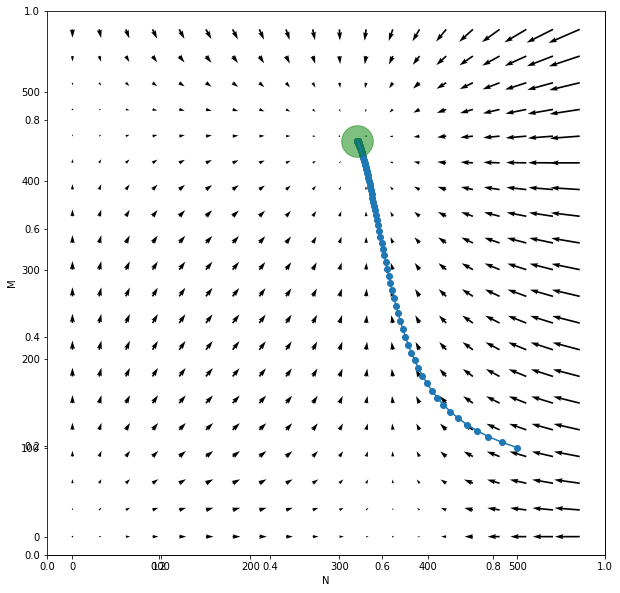

In [59]:
lv_args = {
        'lam' : [1.2, 1.1],    # fecundity
        'p' : [0.5, 0.9],      # death prob
        'K' : [2000, 5000],      # carrying capacity
        'a' : [0.1, 0.1]  # encounter rate
    }
do_plot(lv_args)

And, here is a stochastic simulation trajectory.
(Run again to add more.)

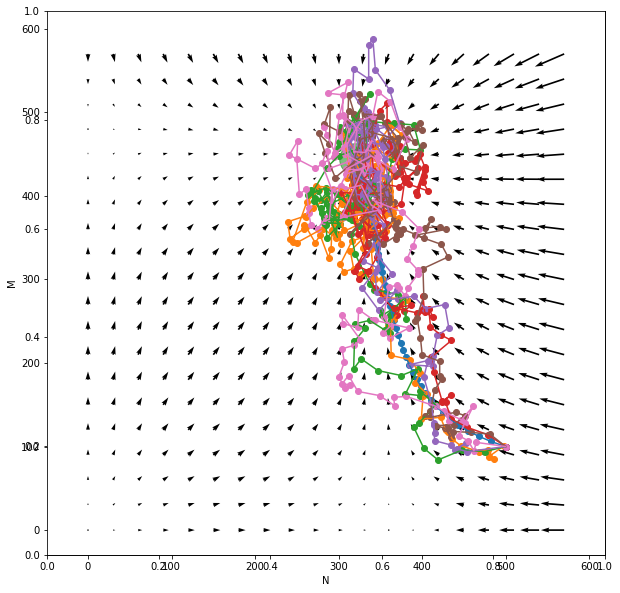

In [39]:
# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)
ax.plot(N, M)
ax.scatter(N, M)
fig

### Exercise

If $K_0 \log(\lambda_0) < a_0 K_1 \log(\lambda_1)$
and/or $K_1 \log(\lambda_1) < a_1 K_0 \log(\lambda_0)$
then there is no stable equilibrium with both species coexisting.
Investigate with simulations to verify this,
and explain intuitively why coexistence fails.

### Non-Homework

We can get very different behavior of this system
for different values of $a_0$ and $a_1$.
Here is a taxonomy:

| $a_0$ | $a_1$ | interaction |
|-------|-------|-------------|
|   -   |   -   | mutualism   |
|   -   |   0   | commensal   |
|   +   |   -   | parasitic   |
|   +   |   +   | competition |

Plot simulation results in phase space
of example parameters for each of the four interactions,
both (a) with stable coexistence,
and (b) without (where one goes extinct).
Explain intuitively what determines this transition.

## Isoclines

A nice way to look at phase plots
is to draw on them the *isoclines*,
i.e., the lines along which each variable does not change.
We saw above that $N$ does not change if
$$\begin{aligned}
  N + a_0 M &= K_0 \log(\lambda_0),
\end{aligned}$$
and $M$ does not change if
$$\begin{aligned}
  a_1 N + M &= K_1 \log(\lambda_1) . 
\end{aligned}$$
These are just *straight lines* in phase space.

In [ ]:
xx = np.array([0.0, 600])
ax.plot(lv_args['K'][0] * np.log(lv_args['lam'][0]) - xx * lv_args['a'][0], xx)
ax.plot(xx, lv_args['K'][1] * np.log(lv_args['lam'][1]) - xx * lv_args['a'][1])
fig

### Another set of parameters 

Here's fun set of parameters.

In [ ]:
lv_args = {
        'lam' : [2.0, 2.9],    # fecundity
        'p' : [0.9, 0.6],      # survival prob
        'K' : [2000, 1500],    # carrying capacity
        'a' : [0.5, 0.5]       # encounter rate
    }

# random simulation
N, M = run_sim_2d([500], [100], lv_gen, 120, dtype='int',
                    **lv_args)

# deterministic
tN, tM = run_sim_2d([500], [100], lv_eqn, 120, dtype='float',
                    **lv_args)
equil = np.fmin(2000, np.fmax(0.0, lv_equil(**lv_args)))

fig = phase_plot(lv_eqn, xlim=[0, 2000], ylim=[0, 2000], nx=20, ny=20,
                 **lv_args)
ax = fig.gca()
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.plot(N, M)
ax.scatter(N, M)
ax.scatter(equil[0], equil[1], s=1000, c='g', alpha=0.5)
ax.axis('equal')

# Susceptible-Infected

The parameters are:

- $\lambda$ : birth rate of new individuals (`lambda`)
- $c$ : per capita encounter rate
- $a$ : transmission rate per encounter
- $\rho$ : recovery rate (`rho`)
- $\mu$ : death rate of susceptible individuals (`mu`)
- $\delta$ : death rate of infected individuals (`delta`)

The equations for the number of susceptible ($S$) 
and the number of infected ($I$) individuals are:
$$\begin{aligned}
  \frac{dS}{dt} &= \lambda - \mu S - a c S I + \rho I \\
  \frac{dI}{dt} &= a  c S I - \delta I - \rho I  
\end{aligned}$$


In [ ]:
def SI_eqn(N, M, dt, lam, c, a, rho, mu, delta):
    next_N = N +  dt * (lam - mu * N - a * c * N * M + rho * M)
    next_M = M + dt * (a * c * N * M - delta * M - rho * M)
    return next_N, next_M

SI_args = {'dt' : 0.5, 'lam' : 4, 'c' : 0.01, 'a' : 0.1, 'rho' : 0.2, 'mu' : 0.01, 'delta' : 0.02}

tN, tM = run_sim_2d([200, 200, 280, 270], [10, 100, 10, 100], SI_eqn, 1000, dtype='float',
               **SI_args)

plt.rcParams['figure.figsize'] = [10, 10]
fig = phase_plot(SI_eqn, xlim=[180, 300], ylim=[0, 150], nx=20, ny=20,
                 **SI_args)
ax = fig.gca()
ax.plot(tN, tM)
ax.scatter(tN, tM)
ax.axis('equal')
plt.xlabel("S")
plt.ylabel("I")

In [ ]:
def SI_gen(S, I, dt, lam, c, a, rho, mu, delta):
    # rescale rates by dy
    lam *= dt
    c *= dt
    rho *= dt
    mu *= dt
    delta *= dt
    nsims = len(S)
    assert(nsims == len(I))
    # birth
    S += np.random.poisson(lam)
    # deaths
    S -= np.random.binomial(S, mu, nsims)
    I -= np.random.binomial(I, delta, nsims)
    # infections
    for k in range(nsims):
        infective_encouters = np.random.binomial(I[k], a*c, S[k])
        new_infections = sum(infective_encouters > 0)
        S[k] -= new_infections
        I[k] += new_infections
    # recovery
    recoveries = np.random.binomial(I, rho, nsims)
    I -= recoveries
    S += recoveries
    return S, I

N, M = run_sim_2d([200, 200, 280, 270], 
                  [10, 100, 10, 100], 
                  SI_gen, 100, dtype='int',
               **SI_args)
ax.plot(N, M)
ax.scatter(N, M)
fig

**Note:** The simulations aren't quite following the arrows. Why not?
Well, the arrows are following "the SI model", defined as the differential equation above.
That's similar, but not the same as, the mean map for our stochastic model!
What's different? Several things: for instance, the "recovery" term should be $\rho (1-\delta) I$,
instead of $\rho I$, because individuals who've died can't recover.
And, the "infection" term is $(1 - (1-ac)^I)S$, not $acSI$.
Setting $dt$ to be small makes the differences minimal, however.

## Homework: Make a model

Next, you will design a stochastic version of this
and simulate from it.